In [268]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [269]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

In [270]:
# Use alternative encoding to avoid UnicodeDecodeError
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')

# Calculate 10% of the total number of rows
sample_size = int(df.height * 0.1)

# Get a 10% random sample of the data
df = df.sample(n=sample_size, with_replacement=False, shuffle=True, seed=42)

print(df)

shape: (32_303, 47)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ NoticeId  ┆ Title     ┆ Sol#      ┆ Departmen ┆ … ┆ CountryCo ┆ Additiona ┆ Link      ┆ Descript │
│ ---       ┆ ---       ┆ ---       ┆ t/Ind.Age ┆   ┆ de        ┆ lInfoLink ┆ ---       ┆ ion      │
│ str       ┆ str       ┆ str       ┆ ncy       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆           ┆ ---       ┆   ┆ str       ┆ str       ┆           ┆ str      │
│           ┆           ┆           ┆ str       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ bc5e5f04c ┆ 15--FAIRI ┆ N0038322R ┆ DEPT OF   ┆ … ┆ USA       ┆           ┆ https://s ┆          │
│ 916465799 ┆ NG,AIRCRA ┆ F342      ┆ DEFENSE   ┆   ┆           ┆           ┆ am.gov/op ┆          │
│ 33a4c0bdc ┆ FT        ┆           ┆           ┆   ┆           ┆      

In [271]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)

In [272]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 32303         ┆ 0              │
│ title                 ┆ 24153         ┆ 0              │
│ sol_                  ┆ 29539         ┆ 0              │
│ department_ind_agency ┆ 69            ┆ 0              │
│ cgac                  ┆ 66            ┆ 0              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 1066          ┆ 0              │
│ countrycode           ┆ 43            ┆ 0              │
│ additionalinfolink    ┆ 1             ┆ 0              │
│ link                  ┆ 32303         ┆ 0              │
│ description           ┆ 26677         ┆ 0              │
└───────────────────────┴───────────────┴

In [273]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code', 'office',
                     'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 
                     'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 
                     'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'awardnumber',
                     'awarddate', 'awardee', 'state', 'city', 'zipcode', 'countrycode', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [274]:
df2022.schema

Schema([('noticeid', String),
        ('title', String),
        ('sol_', String),
        ('department_ind_agency', String),
        ('cgac', Int64),
        ('sub_tier', String),
        ('fpds_code', String),
        ('office', String),
        ('aac_code', String),
        ('posteddate', String),
        ('type', String),
        ('basetype', String),
        ('archivetype', String),
        ('archivedate', String),
        ('setasidecode', String),
        ('setaside', String),
        ('responsedeadline', String),
        ('naicscode', String),
        ('classificationcode', String),
        ('popstreetaddress', String),
        ('popcity', String),
        ('popstate', String),
        ('popzip', String),
        ('popcountry', String),
        ('active', String),
        ('awardnumber', String),
        ('awarddate', String),
        ('award_', String),
        ('awardee', String),
        ('primarycontacttitle', String),
        ('primarycontactfullname', String),
        ('pr

In [275]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Handle potential errors if 'award_' contains non-numeric values
# You can also choose to fill missing values or drop rows with invalid 'award_' entries
df = df.drop_nulls(subset=['award_'])
df

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""bc5e5f04c91646579933a4c0bdc456…","""15--FAIRING,AIRCRAFT""","""N0038322RF342""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-06-30 07:10:57.475-04""","""Award Notice""","""Award Notice""","""autocustom""","""2022-07-14""","""""","""""","""""","""""","""1560""","""""","""""","""""","""""","""""","""No""","""N0038322FX900""","""2022-06-29""","""1165526""","""SIKORSKY AIRCRAFT CORP, STRATF…","""""","""KAITLYN R. SAWICKI, N732.50, P…","""KAITLYN.SAWICKI@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/bc5e5f04c9…",""""""
"""a233c35e1ba243928140f6d84b9611…","""V127--Armored Car Services""","""36C24622Q0748""","""VETERANS AFFAIRS, DEPARTMENT O…",36,"""VETERANS AFFAIRS, DEPARTMENT O…","""3600""","""246-NETWORK CONTRACTING OFFICE…","""36C246""","""2022-07-05 09:42:28.136-04""","""Solicitation""","""Solicitation""","""autocustom""","""2022-08-11""","""""","""""","""2022-07-12T14:00:00-04:00""","""561613""","""V127""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""null ""","""Contracting Officer""","""Paul O Waite""","""Paul.Waite@va.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""VA""","""HAMPTON""","""23667""","""USA""","""""","""https://sam.gov/opp/a233c35e1b…","""Amendment to Solicitation to u…"
"""26f9fe72dcfc4e03b9268f7e869e40…","""IDIQ for Financial Management …","""75P00120R00180""","""HEALTH AND HUMAN SERVICES, DEP…",75,"""OFFICE OF THE ASSISTANT SECRET…","""7570""","""PROGRAM SUPPORT CENTER ACQ MGM…","""75P001""","""2022-02-07 10:59:47.707-05""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""autocustom""","""2022-05-30""","""8A""","""8(a) Set-Aside (FAR 19.8)""","""2022-02-21T11:00:00-05:00""","""541219""","""R703""","""""","""Bethesda""","""MD""","""20814""","""USA""","""No""","""""","""""","""""","""""","""""","""Wendy Cruz""","""wendy.cruz@psc.hhs.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""MD""","""ROCKVILLE""","""20857""","""USA""","""""","""https://sam.gov/opp/26f9fe72dc…","""This is a combined synopsis/so…"
"""7df37f39a80f4e549a8082ab149982…","""Animal Care and Technical Proc…","""75F40122R1259563""","""HEALTH AND HUMAN SERVICES, DEP…",75,"""FOOD AND DRUG ADMINISTRATION""","""7524""","""FDA NATIONAL CENTER FOR TOXICO…","""75DAEC""","""2022-04-12 17:19:47.468-04""","""Sources Sought""","""Sources Sought""","""auto15""","""""","""""","""""","""2022-04-27T14:00:00-05:00""","""541714""","""R416""","""""","""Jefferson""","""AR""","""72079""","""USA""","""No""","""""","""""","""""","""""","""""","""Tim Walbert""","""timothy.walbert@fda.hhs.gov""","""8705437267""","""""","""""","""""","""""","""""","""""","""OFFICE""","""MD""","""Silver Spring""","""20993""","""USA""","""""","""https://sam.gov/opp/7df37f39a8…","""MARKET RESEARCH PURPOSES ONLY …"
"""0054de1834474a90820b5234927a22…","""Septic Pumps Replacement, Quec…","""W912WJ22Q0156""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""W2SD ENDIST NEW ENGLAND""","""W912WJ""","""2022-09-23 13:51:05.796-04""","""Solicitati

In [276]:
!pip install --upgrade polars

In [277]:
# Calculate total awards per sub_tier
total_awards_df = df.group_by('sub_tier').agg(pl.col('award_').sum().alias('total_award'))
# Sort departments alphabetically
total_awards_df = total_awards_df.sort('sub_tier')
total_awards_df

sub_tier,total_award
str,str
"""""",null
"""ADMINISTRATION FOR CHILDREN AN…",null
"""ADMINISTRATIVE OFFICE OF THE U…",null
"""AGENCY FOR HEALTHCARE RESEARCH…",null
"""AGENCY FOR INTERNATIONAL DEVEL…",null
…,…
"""US TRANSPORTATION COMMAND (UST…",null
"""USDA, DEPARTMENTAL ADMINISTRAT…",null
"""USDA, OFFICE OF PROCUREMENT AN…",null


In [278]:
# Calculate total awards per department_ind_agency
total_awards_df = df.group_by('department_ind_agency').agg(pl.col('award_').sum().alias('total_award'))

# Sort departments alphabetically
total_awards_df = total_awards_df.sort('department_ind_agency')

# Extract departments and total awards
departments = total_awards_df['department_ind_agency'].to_list()
total_awards = total_awards_df['total_award'].to_list()

# Determine the number of chunks
num_chunks = 4
chunk_size = len(departments) // num_chunks
chunks = [departments[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining departments, add them to the last chunk
if len(departments) % num_chunks != 0:
    chunks[-1].extend(departments[num_chunks * chunk_size:])

# Similarly split total_awards into chunks
total_awards_chunks = [total_awards[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]
if len(total_awards) % num_chunks != 0:
    total_awards_chunks[-1].extend(total_awards[num_chunks * chunk_size:])

In [279]:
# Clean the 'award_' column by removing '$' and ',' and converting to float
df = df.with_columns([
    pl.col('award_')
    .str.replace_all(r'[\$,]', '')  # Remove '$' and ','
    .cast(pl.Float64, strict=False)  # Convert to float, allow failures
    .alias('award_')
])

# Drop rows where 'award_' could not be converted to float
df = df.drop_nulls(subset=['award_'])

# Calculate total awards per 'sub_tier'
total_awards_df = df.group_by('sub_tier').agg(
    pl.col('award_').sum().alias('total_award')
)

# Sort sub_tiers alphabetically
total_awards_df = total_awards_df.sort('sub_tier')

# Extract sub_tiers and total awards
departments = total_awards_df['sub_tier'].to_list()
total_awards = total_awards_df['total_award'].to_list()

# Ensure departments and total_awards are properly defined
print("Number of departments:", len(departments))
print("Number of total awards:", len(total_awards))

Number of departments: 83
Number of total awards: 83


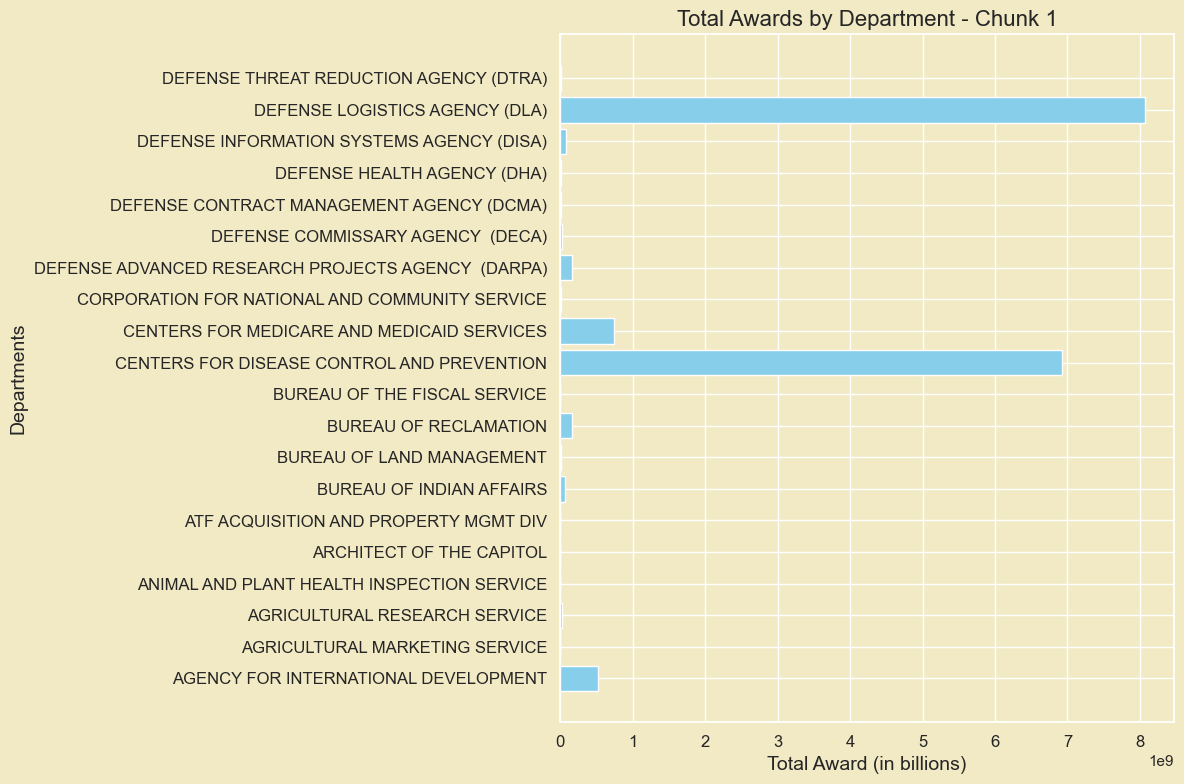

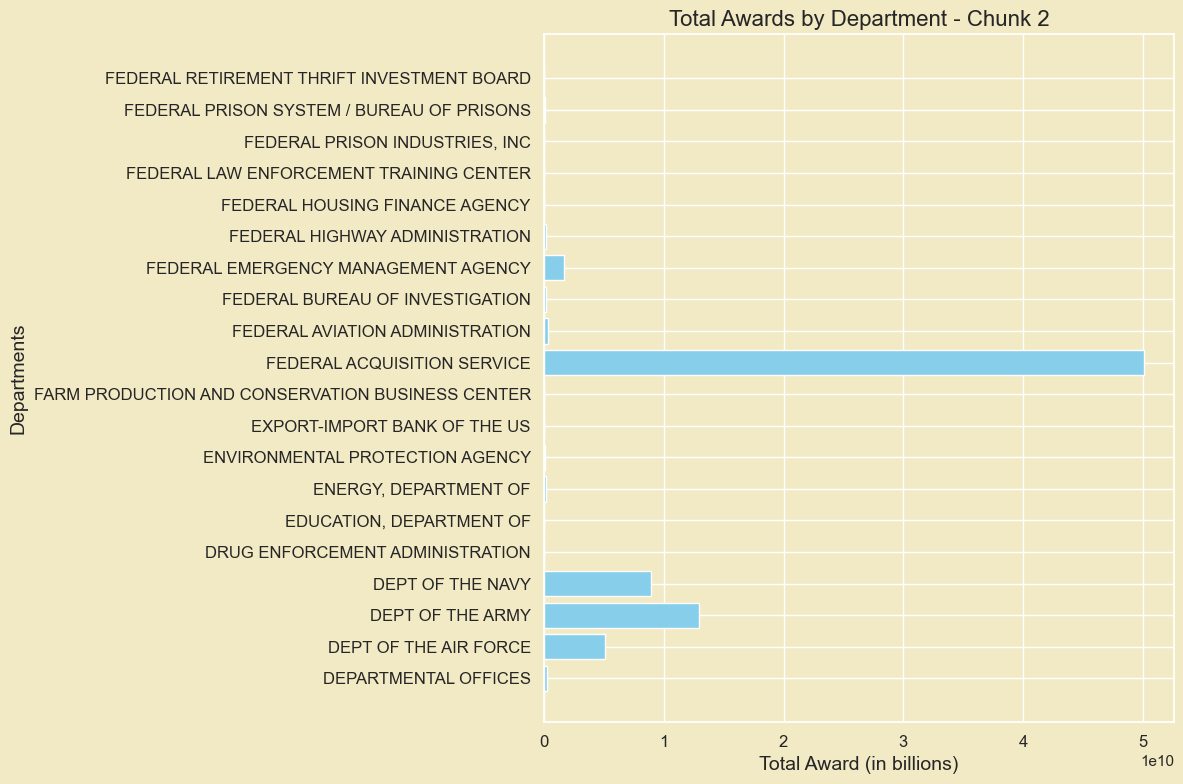

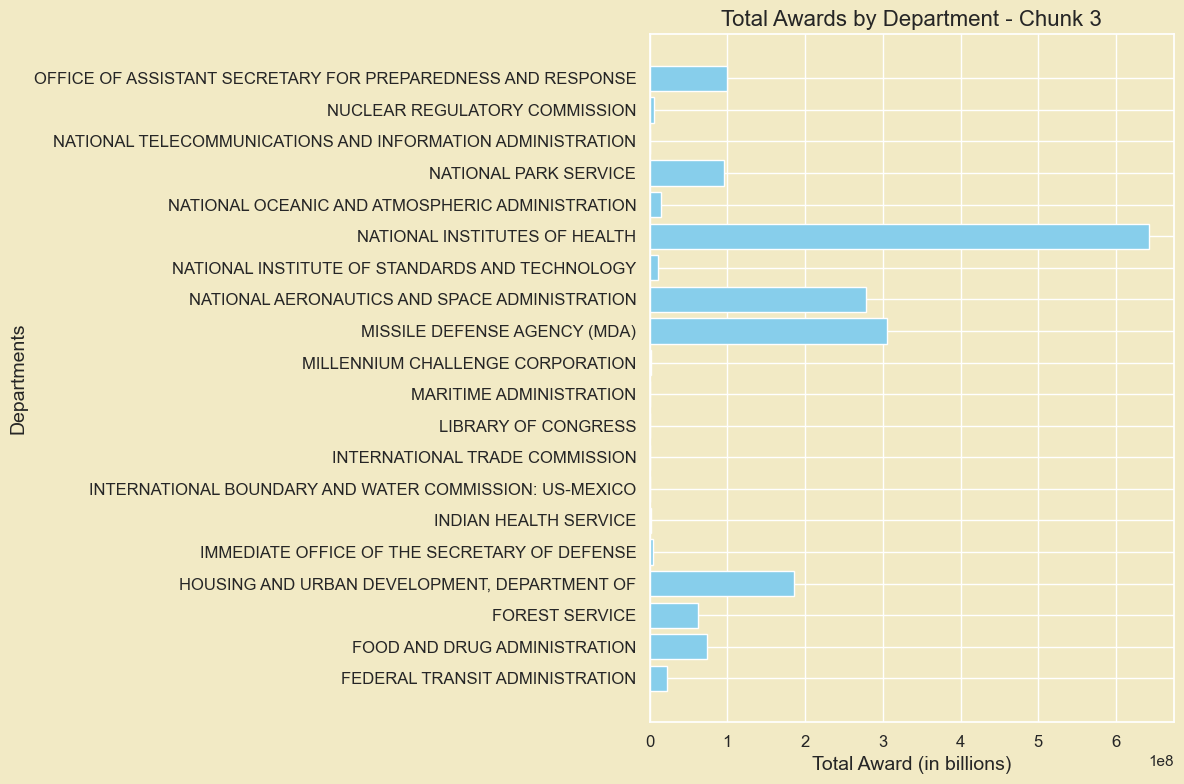

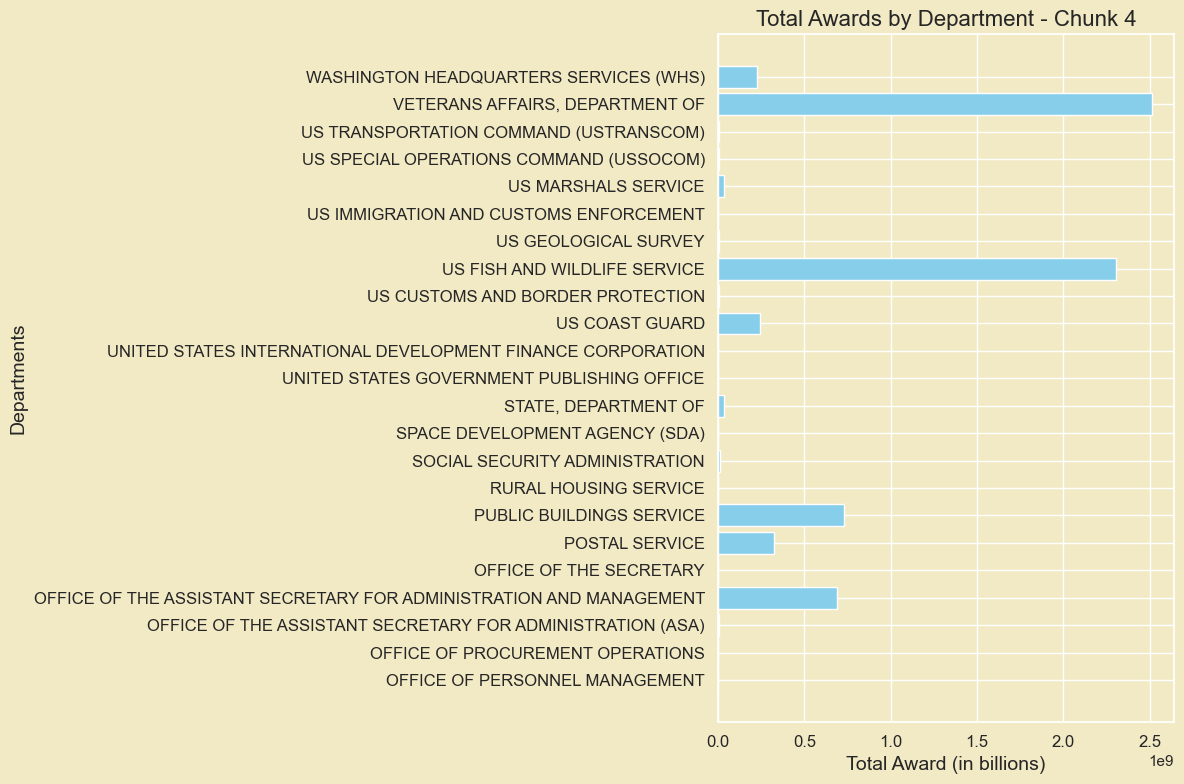

In [280]:
# Ensure departments and total_awards are defined
if departments is not None and total_awards is not None:
    # Determine the number of chunks
    num_chunks = 4
    chunk_size = len(departments) // num_chunks
    chunks = [departments[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

    # If there are remaining departments, add them to the last chunk
    if len(departments) % num_chunks != 0:
        chunks[-1].extend(departments[num_chunks * chunk_size:])

    # Similarly split total_awards into chunks
    total_awards_chunks = [total_awards[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]
    if len(total_awards) % num_chunks != 0:
        total_awards_chunks[-1].extend(total_awards[num_chunks * chunk_size:])

    # Plot histograms for each chunk in separate figures
    for idx, (dept_chunk, award_chunk) in enumerate(zip(chunks, total_awards_chunks), 1):
        plt.figure(figsize=(12, 8))
        plt.barh(dept_chunk, award_chunk, color='skyblue')

        # Add titles and labels
        plt.title(f'Total Awards by Department - Chunk {idx}', fontsize=16)
        plt.xlabel('Total Award (in billions)', fontsize=14)
        plt.ylabel('Departments', fontsize=14)

        # Format tick labels for readability
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # Display the plot
        plt.tight_layout()
        plt.show()
else:
    print("Error: 'departments' or 'total_awards' is not defined.")

In [281]:
# Sort the DataFrame in descending order of total awards
total_awards_df = total_awards_df.sort('total_award')

# Extract departments and total awards after sorting
departments = total_awards_df['department_ind_agency'].to_list()
total_awards = total_awards_df['total_award'].to_list()

# Ensure departments and total_awards are defined
if departments and total_awards:
    # Determine the number of chunks
    num_chunks = 4
    chunk_size = len(departments) // num_chunks
    chunks = [departments[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

    # If there are remaining departments, add them to the last chunk
    if len(departments) % num_chunks != 0:
        chunks[-1].extend(departments[num_chunks * chunk_size:])

    # Similarly split total_awards into chunks
    total_awards_chunks = [total_awards[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]
    if len(total_awards) % num_chunks != 0:
        total_awards_chunks[-1].extend(total_awards[num_chunks * chunk_size:])

    # Plot bar charts for each chunk in separate figures
    for idx, (dept_chunk, award_chunk) in enumerate(zip(chunks, total_awards_chunks), 1):
        plt.figure(figsize=(12, 8))
        plt.barh(dept_chunk, award_chunk, color='skyblue')

        # Add titles and labels
        plt.title(f'Total Awards by Department - Chunk {idx}', fontsize=16)
        plt.xlabel('Total Award (in billions)', fontsize=14)
        plt.ylabel('Departments', fontsize=14)

        # Format tick labels for readability
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # Invert y-axis to show highest values at the top
        plt.gca().invert_yaxis()

        # Display the plot
        plt.tight_layout()
        plt.show()
else:
    print("Error: 'departments' or 'total_awards' is not defined.")

ColumnNotFoundError: "department_ind_agency" not found

In [ ]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format
df2022

In [ ]:
award_=df2022['primarycontactemail', 'primarycontactfullname','primarycontactphone', 'award_'].unique()
award_

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(award__df):
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'] != "\"\""]
    # Sort by column: 'award_' (descending)
    award__df = award__df.sort_values(['award_'], ascending=[False])
    # Convert 'award_' to numeric and assign to 'award_amount'
    award__df['award_amount'] = pd.to_numeric(award__df['award_'], errors='coerce')
    return award__df

# Loaded variable 'award_' from kernel state
award__df = award_.to_pandas()

award__df_clean = clean_data(award__df.copy())
award__df_clean.head()

In [ ]:
# Filter out rows where any of the specified columns are null
filtered_df = award__df_clean.dropna(subset=['primarycontactemail', 'primarycontactfullname', 'primarycontactphone', 'award_amount'])

# Group by the specified columns and calculate the sum of award_amount
grouped_df = filtered_df.groupby(['primarycontactemail', 'primarycontactfullname', 'primarycontactphone']).agg({'award_amount': 'sum'}).reset_index()

# Sort the dataframe by award_amount in descending order and select the top 50
top_50_df = grouped_df.sort_values(by='award_amount', ascending=False).head(25)

# Round the award_amount to 1 decimal place and format with thousands separators
top_50_df['award_amount'] = top_50_df['award_amount'].apply(lambda x: f"{x:,.1f}")

# Display the result
print(top_50_df)

In [ ]:
# Convert award_amount back to float for plotting
top_50_df['award_amount'] = top_50_df['award_amount'].str.replace(',', '').astype(float)

# Plot the top 50 award amounts
plt.figure(figsize=(14, 10))
sns.barplot(x='award_amount', y='primarycontactfullname', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact Fullname')
plt.tight_layout()
plt.show()

In [ ]:
# Concatenate email addresses with primary contact names
top_50_df['contact_info'] = top_50_df['primarycontactfullname'] + ' (' + top_50_df['primarycontactemail'] + ')'

# Plot the top 50 award amounts
plt.figure(figsize=(20, 16))
sns.barplot(x='award_amount', y='contact_info', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact (Email)')
plt.tight_layout()
plt.show()

In [ ]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

In [ ]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

In [ ]:
df2022_df_clean.columns

In [ ]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train)

In [ ]:
print(X_test)

In [ ]:
print(y_train)

In [ ]:
print(y_test)

In [ ]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [ ]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [ ]:
X_train.columns

In [ ]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

In [ ]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns ]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

In [ ]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [ ]:
# Remove the specified columns
X_train = X_train.drop(columns=['noticeid', 'additionalinfolink', 'link'])
X_test = X_test.drop(columns=['noticeid', 'additionalinfolink', 'link'])

# Display the updated dataframes
print(X_train.head())
print(X_test.head())

In [ ]:
# Remove '$' and ',' then convert to float
#y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [ ]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

In [ ]:
# Identify object columns
object_columns = X_train.select_dtypes(include=['object']).columns

# Clean columns containing '$'
for col in object_columns:
    if X_train[col].astype(str).str.contains('\$').any():
        X_train[col] = X_train[col].str.replace(r'[\$,]', '', regex=True).astype(float)
        X_test[col] = X_test[col].str.replace(r'[\$,]', '', regex=True).astype(float)

# Drop non-numeric columns without '$'
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

# Ensure X_train and X_test have the same columns
X_test = X_test[X_train.columns]


In [ ]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

In [ ]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [ ]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(14, 12))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Predictions')
plt.show()

In [ ]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [ ]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, 
                       posted_date, contract_type, base_type, archive_type, darchive_date, 
                       set_aside_code, set_aside, response_deadline, naics_code, 
                       classification_code, pop_street_address, pop_city, pop_state,
                       pop_zip, pop_country, award_number, award_date, award_amount,
                       awardee, primary_contact_title, primary_contact_fullname,
                       primary_contact_email, primary_contact_phone, primary_contact_fax, 
                       secondary_contact_title, secondary_contact_fullname, secondary_contact_email, 
                       secondary_contact_phone, secondary_contact_fax, organization_type, state, 
                       city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [ ]:
X_train.dtypes.to_frame('Data Type')

In [ ]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

In [ ]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(30,18), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Sort the columns by name
sorted_columns = sorted(X_train.columns)

# Split columns into four roughly equal parts
num_chunks = 4
chunk_size = len(sorted_columns) // num_chunks
chunks = [sorted_columns[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining columns, add them to the last chunk
if len(sorted_columns) % num_chunks != 0:
    chunks[-1].extend(sorted_columns[num_chunks * chunk_size:])

# Plot histograms for each chunk
for idx, chunk in enumerate(chunks, 1):
    plt.figure(figsize=(32, 15))
    X_train[chunk].hist(bins=30, xlabelsize=8, ylabelsize=8)
    plt.suptitle(f'Histogram Chunk {idx}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
unique_values = X_train.nunique()
missing_values = X_train.isnull().sum()

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'Missing Values': missing_values
})

In [ ]:
summary_sorted = summary.sort_values(by='Unique Values', ascending=True)

print(summary_sorted)

In [ ]:
X_train.info()

In [ ]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")

In [ ]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# 1. Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)  # Top 20 features

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# 2. Coefficient Analysis for Ridge Regression
coefficients = ridge_model.coef_
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False).head(20)  # Top 20 positive coefficients

plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=coef_df, palette='coolwarm')
plt.title('Top 20 Coefficients - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# 3. SHAP Values for Model Explainability
# Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.title('SHAP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
# 4. Residual Plots
# Random Forest Residuals
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(14, 10))
sns.histplot(rf_residuals, kde=False, color='blue')
plt.title('Residuals Distribution - Random Forest')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Ridge Regression Residuals
ridge_residuals = y_test - ridge_predictions
plt.figure(figsize=(14, 10))
sns.histplot(ridge_residuals, kde=True, color='green')
plt.title('Residuals Distribution - Ridge Regression')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# 5. Actual vs. Predicted Scatter Plots
plt.figure(figsize=(20, 12))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Random Forest')

# Ridge Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=ridge_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Ridge Regression')

plt.tight_layout()
plt.show()

In [ ]:
# Plot the results
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()